# Import Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from PIL import Image

! pip install visualkeras
import visualkeras
import os

import warnings
warnings.filterwarnings('ignore')

# Load Dataset & Perform EDA

In [79]:
dir = '/kaggle/input'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))
             
df = pd.DataFrame(columns=['Image','Label'])
df['Image']=path
df['Label']=label

df = shuffle(df)
df = df.reset_index(drop=True)

### Observing Dataset

In [80]:
# Total number of samples
len(df)

11525

In [81]:
# Check first 5 rows
df.head()

,Image,Label
0,/kaggle/input/eyes-rtte/maleeyes/3188.jpg,maleeyes
1,/kaggle/input/eyes-rtte/femaleeyes/802.jpg,femaleeyes
2,/kaggle/input/eyes-rtte/femaleeyes/2485.jpg,femaleeyes
3,/kaggle/input/eyes-rtte/femaleeyes/2862.jpg,femaleeyes
4,/kaggle/input/eyes-rtte/femaleeyes/3431.jpg,femaleeyes


In [82]:
# Check last 5 columns
df.tail()

,Image,Label
11520,/kaggle/input/eyes-rtte/maleeyes/6818.jpg,maleeyes
11521,/kaggle/input/eyes-rtte/femaleeyes/3774.jpg,femaleeyes
11522,/kaggle/input/eyes-rtte/femaleeyes/4123.jpg,femaleeyes
11523,/kaggle/input/eyes-rtte/maleeyes/3554.jpg,maleeyes
11524,/kaggle/input/eyes-rtte/femaleeyes/2212.jpg,femaleeyes


In [83]:
# Column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   11525 non-null  object
 1   Label   11525 non-null  object
dtypes: object(2)
memory usage: 180.2+ KB


In [84]:
# check total count and frequency of each label
df.describe()

,Image,Label
count,11525,11525
unique,11525,2
top,/kaggle/input/eyes-rtte/maleeyes/3188.jpg,maleeyes
freq,1,6323


There are total of 11525 Images in the entire dataset, having 2 labels [maleeyes, femaleeyes]. Frequency of maleeyes is greater then frequency of female eyes.

In [85]:
# check for null values or missing labels
df.isna().sum()

Image    0
Label    0
dtype: int64

No null entries present in dataset.

In [86]:
# check for duplicate entries
df.duplicated().any()

False

All the samples in the dataset are unique

maleeyes      6323
femaleeyes    5202
Name: Label, dtype: int64


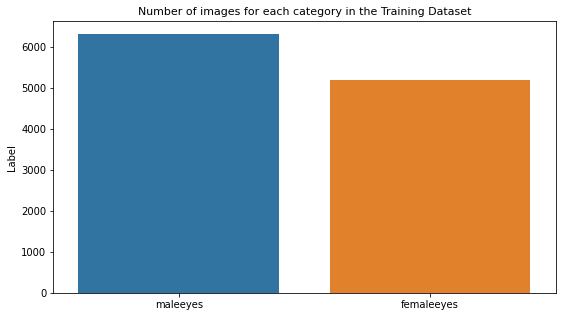

In [87]:
# Count number of samples for each category [Male, Female]
vc = df['Label'].value_counts()
print(vc)

plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

The dataset has 6323 images of male and 5202 images of female eyes

#### Balancing Dataset

In [88]:
# Using downsampling to balance the dataset, 
# as there is not a big difference in the total number of samples in both categories

# Dividing majority and minority classes
df_major = df[df.Label=='maleeyes']
df_minor = df[df.Label=='femaleeyes']

df_major_sample = resample(df_major,
               replace=False,  # Down sample without replacement
               n_samples=5202,   # Number to match minority class
               random_state=42)
  
# Combine both samples
df = pd.concat([df_major_sample, df_minor])
df = shuffle(df)
df = df.reset_index(drop=True)

# Display count of data points in both class
print(df.Label.value_counts())

df.describe()

maleeyes      5202
femaleeyes    5202
Name: Label, dtype: int64


,Image,Label
count,10404,10404
unique,10404,2
top,/kaggle/input/eyes-rtte/maleeyes/3541.jpg,maleeyes
freq,1,5202


Using the downsampling technique we removed extra samples from maleeyes, now both labels have 5202 samples having all unique values. 

### Observing the images

Here we can see that size of both images are not same, hence we will resize female images to 54x54

In [89]:
# Get index of male and female eye
xx = df[df['Label'] == 'femaleeyes'].index[0] # index of female eye
xy = df[df['Label'] == 'maleeyes'].index[0] # index of male eye

Text(0.5, 1.0, 'femaleeyes')

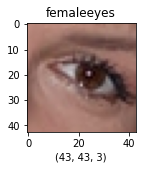

In [90]:
# visualize female eye
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["Image"][xx])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][xx])

Text(0.5, 1.0, 'maleeyes')

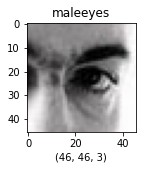

In [91]:
# visualize male eye
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["Image"][xy])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][xy])

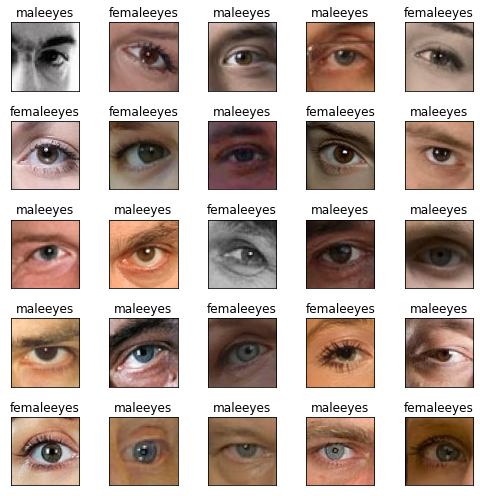

In [92]:
# plot more random images from dataset
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["Image"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [93]:
# Checking image size
female_eye_size = plt.imread(df["Image"][xx])
print(female_eye_size.shape, '==>',  df['Label'][xx])

male_eye_size = plt.imread(df["Image"][xy])
print(male_eye_size.shape, '==>',  df['Label'][xy])

(43, 43, 3) ==> femaleeyes
(46, 46, 3) ==> maleeyes


Here all the images have varying sizes, we should resize all the images to equal size for better classification.

In [94]:
# Check how many different sized images are there

size_list=set() # empty set for checking total different sizes of images

for x in range(len(df['Image'])):
    size_list.add(plt.imread(df["Image"][x]).shape)

print(len(size_list))
print('Smallest size :', list(sorted(size_list))[0])
print('Largest size :', list(sorted(size_list))[-1])

64
Smallest size : (41, 41, 3)
Largest size : (113, 113, 3)


The dataset contains images with 65 different sizes, ranging from 41x41 to 117x117.
We will now resize them to 64x64 size.

In [95]:
# Convert image path to array of image using cv2
size = (64,64)
df1 = df.copy()

size_list = set()
for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_list.add(image.shape)
    df1['Image'][i] = image.flatten()

In [96]:
# Check shape after resizing
size_list

{(64, 64, 3)}

Now all the images have same size ==> 64x64, and falttened to perform KNN

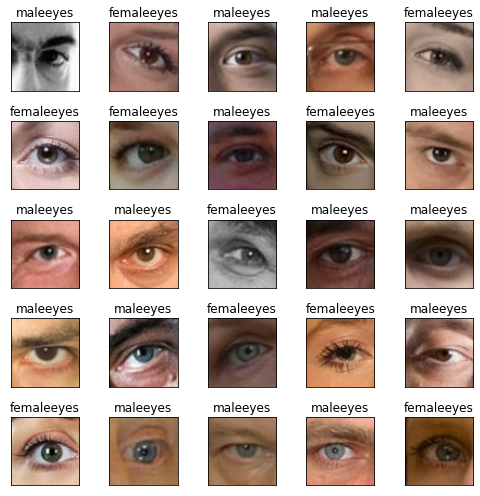

In [97]:
# Finally let's see some random images again

fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(df1.Image[i].reshape(64,64,3))
    ax.set_title(df1["Label"][i])
plt.tight_layout()
plt.show()

In [98]:
# Convert labels to numeric values

LE = LabelEncoder()

df1['Label'] = np.asarray(LE.fit_transform(df1["Label"]))

display(df1.head())

,Image,Label
0,"[143, 141, 142, 146, 144, 145, 149, 147, 148, ...",1
1,"[183, 135, 123, 185, 137, 125, 187, 139, 127, ...",0
2,"[218, 189, 183, 218, 189, 183, 218, 188, 181, ...",1
3,"[211, 148, 113, 211, 148, 114, 212, 149, 114, ...",1
4,"[201, 174, 155, 201, 174, 155, 200, 172, 157, ...",0


# KNN

In [99]:
# Function to reset the index and reshape the array 
def cleaned(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

In [100]:
# Split data into train and test
X_train, X_test,y_train, y_test = train_test_split(df1.Image, df1.Label, test_size = 0.2, random_state = 7)

X_train, X_test,y_train, y_test = cleaned([X_train, X_test,y_train, y_test])

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(8323, 12288) (2081, 12288)
(8323, 1) (2081, 1)


In [101]:
# Applying KNN multiple times to find best value of K

error_rate = []
acc = []

for i in range(10,25):
 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

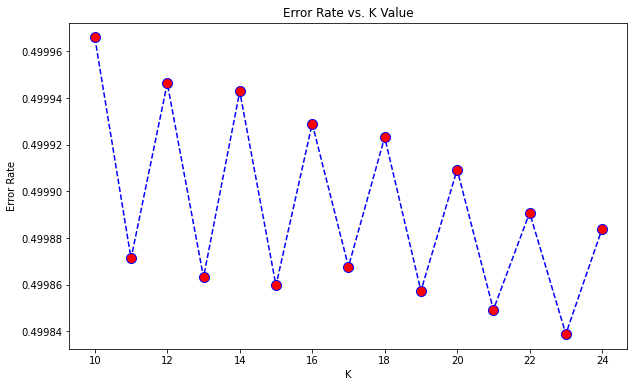

In [102]:
# Elbow plot to see optimum value of K
plt.figure(figsize=(10,6))
plt.plot(range(10,25),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [103]:
# NOW WITH K=16
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

In [104]:
# Print accuracy
%time
# 84.1 - Best Accuracy found 
print('KNN Accuracy: %.3f' % accuracy_score(y_test,pred))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.5 µs
KNN Accuracy: 0.832


Text(0.5, 1.0, 'Accuracy Score: 0.8322921672272946')

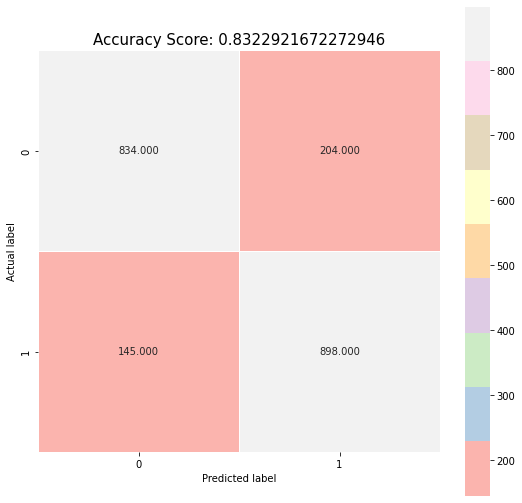

In [105]:
# Confusion Matrix
cm = confusion_matrix(y_test,pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap="Pastel1")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,pred))
plt.title(all_sample_title,size=15)

In [106]:
# Classification report
KNN_Classification_Report = classification_report(y_test,pred)
print(KNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1038
           1       0.81      0.86      0.84      1043

    accuracy                           0.83      2081
   macro avg       0.83      0.83      0.83      2081
weighted avg       0.83      0.83      0.83      2081



We can see from the confusion matrix that our KNN classifier has an accuracy of approx 83.7%, where from 2081 samples, the algorithm correctly identified 840 samples as True Positive, 901 as True Negatives, 193 as False Positive and 147 as False Negatives.

With an average precision of 84%, recall of 84% and f1-score and accuracy of about 0.84. 

# MLP


#### Train Val Test Split

In [107]:
# Deviding df to Train Test and Validation set

X_train, X_val,y_train, y_val = train_test_split(df1.Image, df1.Label, test_size = 0.3, random_state = 7)
X_val, X_test,y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 7)

x_train, x_val, x_test, y_train, y_val, y_test = cleaned([X_train, X_val, X_test, y_train, y_val, y_test])

print("X Train: ", x_train.shape) 
print("X Val: ", x_val.shape) 
print("X Test: ", x_test.shape) 
print("y Train: ", y_train.shape) 
print("y Val: ", y_val.shape) 
print("y test: ", y_test.shape) 

X Train:  (7282,)
X Val:  (1561,)
X Test:  (1561,)
y Train:  (7282, 1)
y Val:  (1561, 1)
y test:  (1561, 1)


In [108]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu), # x if x > 0 else alpha*x 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') # [0, 1]
])

red = len(y_train[y_train>0])
blue = len(y_train) - red
total = len(y_train)
weight_for_red = total / (2 * red) 
weight_for_blue = total / (2 * blue)
class_weight = {0: weight_for_blue, 1: weight_for_red}
print(class_weight)

adam_optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
)


{0: 1.0008246289169873, 1: 0.9991767288693744}


In [110]:
# visualkeras.layered_view(model)

In [111]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
history = model.fit(x_train_scaled, 
          y_train,
          class_weight=class_weight,
          batch_size=64,
          validation_split=0.1,
#           callbacks=[save_best_callback],
          epochs=20)

Epoch 1/20
103/103 [==============================] - 10s 72ms/step - loss: 7.4783 - tp: 2350.0000 - fp: 983.0000 - tn: 2299.0000 - fn: 921.0000 - accuracy: 0.7094 - precision: 0.7051 - recall: 0.7184 - auc: 0.7286 - val_loss: 3.2232 - val_tp: 222.0000 - val_fp: 31.0000 - val_tn: 325.0000 - val_fn: 151.0000 - val_accuracy: 0.7503 - val_precision: 0.8775 - val_recall: 0.5952 - val_auc: 0.8021
Epoch 2/20
103/103 [==============================] - 6s 62ms/step - loss: 3.4043 - tp: 2560.0000 - fp: 722.0000 - tn: 2560.0000 - fn: 711.0000 - accuracy: 0.7813 - precision: 0.7800 - recall: 0.7826 - auc: 0.8144 - val_loss: 2.0516 - val_tp: 339.0000 - val_fp: 108.0000 - val_tn: 248.0000 - val_fn: 34.0000 - val_accuracy: 0.8052 - val_precision: 0.7584 - val_recall: 0.9088 - val_auc: 0.8588
Epoch 3/20
103/103 [==============================] - 6s 63ms/step - loss: 2.1988 - tp: 2648.0000 - fp: 663.0000 - tn: 2619.0000 - fn: 623.0000 - accuracy: 0.8038 - precision: 0.7998 - recall: 0.8095 - auc: 0.83

In [112]:
# Evaluate model
x_test_scaled = scaler.fit_transform(x_test)
score = model.evaluate(x_test_scaled, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.296307772397995
Test accuracy: 720.0


In [113]:
# Predictions 
y_pred = model.predict(x_test_scaled)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

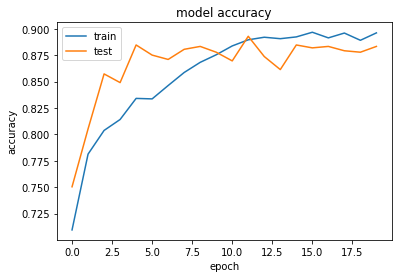

In [114]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

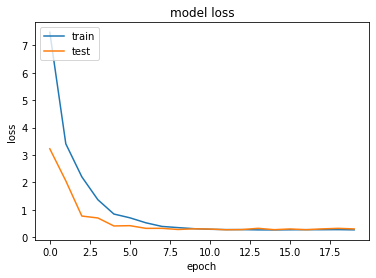

In [115]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [122]:
# Classification report
CNN_Classification_Report = classification_report(y_test,y_pred)
print(CNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       795
           1       0.84      0.94      0.89       766

    accuracy                           0.88      1561
   macro avg       0.89      0.88      0.88      1561
weighted avg       0.89      0.88      0.88      1561



In [117]:
print(KNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1038
           1       0.81      0.86      0.84      1043

    accuracy                           0.83      2081
   macro avg       0.83      0.83      0.83      2081
weighted avg       0.83      0.83      0.83      2081



# CNN

In [118]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import layers

In [ ]:
# Helper code
def to_tensor(_list):
    LIST = []
    for i in range(len(_list)):
        LIST.append(tf.convert_to_tensor(_list[i]))
    return LIST

In [155]:
# Function to reset the index and reshape the array 
def cleaned2(X):
    for i in range(len(X)):
        X[i] = np.stack(X[i].reset_index(drop=True))
    return X

In [169]:
# Convert image path to array of image using cv2
size = (64,64)
df2 = df.copy()

for i in range(len(df)):
    image=cv2.imread(df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    df2['Image'][i] = image
    
# Convert labels to numeric values

LE = LabelEncoder()

df2['Label'] = np.asarray(LE.fit_transform(df2["Label"]))

display(df2.head())

,Image,Label
0,"[[[143, 141, 142], [146, 144, 145], [149, 147,...",1
1,"[[[183, 135, 123], [185, 137, 125], [187, 139,...",0
2,"[[[218, 189, 183], [218, 189, 183], [218, 188,...",1
3,"[[[211, 148, 113], [211, 148, 114], [212, 149,...",1
4,"[[[201, 174, 155], [201, 174, 155], [200, 172,...",0


In [170]:
df2.Image[1].shape

(64, 64, 3)

In [171]:
# Deviding df to Train Test and Validation set

x_train, x_val,y_train, y_val = train_test_split(df2.Image, df2.Label, test_size = 0.4, random_state = 7)
x_val, x_test,y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state = 7)

x_train, x_val, x_test, y_train, y_val, y_test = cleaned2([x_train, x_val, x_test, y_train, y_val, y_test])
x_train, x_val, x_test, y_train, y_val, y_test = to_tensor([x_train, x_val, x_test, y_train, y_val, y_test])

print("X Train: ", x_train.shape) 
print("X Val: ", x_val.shape) 
print("X Test: ", x_test.shape) 
print("y Train: ", y_train.shape) 
print("y Val: ", y_val.shape) 
print("y test: ", y_test.shape) 

X Train:  (6242, 64, 64, 3)
X Val:  (2081, 64, 64, 3)
X Test:  (2081, 64, 64, 3)
y Train:  (6242,)
y Val:  (2081,)
y test:  (2081,)


In [172]:
# Alex-Net Architechture

CNN=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')  
])

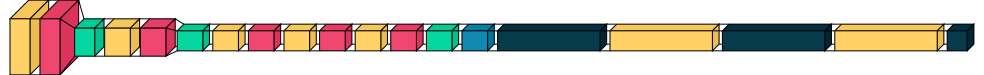

In [173]:
visualkeras.layered_view(CNN)

In [174]:

CNN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [177]:
r=CNN.fit(x_train,y_train,validation_data=(x_val,y_val),
            epochs=5,
#             callbacks=[early_stop,reduce_lr]
           )

Epoch 1/5
196/196 [==============================] - 25s 126ms/step - loss: 0.3913 - accuracy: 0.8257 - val_loss: 0.5108 - val_accuracy: 0.7078
Epoch 2/5
196/196 [==============================] - 24s 124ms/step - loss: 0.3339 - accuracy: 0.8587 - val_loss: 0.5059 - val_accuracy: 0.7492
Epoch 3/5
196/196 [==============================] - 24s 124ms/step - loss: 0.2975 - accuracy: 0.8811 - val_loss: 0.3713 - val_accuracy: 0.8385
Epoch 4/5
196/196 [==============================] - 23s 119ms/step - loss: 0.2672 - accuracy: 0.8917 - val_loss: 0.2883 - val_accuracy: 0.8760
Epoch 5/5
196/196 [==============================] - 24s 124ms/step - loss: 0.2399 - accuracy: 0.9082 - val_loss: 0.2673 - val_accuracy: 0.8847


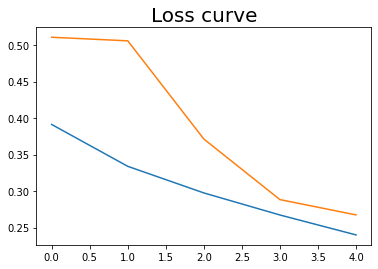

In [189]:
plt.figure(figsize=(8,6))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Loss curve',fontdict={'size':20})
plt.show()


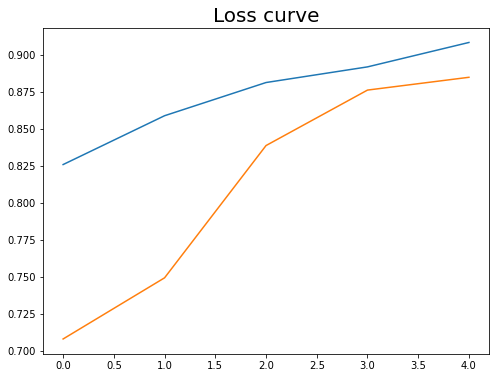

In [191]:
plt.figure(figsize=(8,6))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Loss curve',fontdict={'size':20})
plt.show()

In [185]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

In [186]:
y_pred_CNN = CNN.predict(x_test)
y_pred_CNN = np.round(y_pred_CNN)

recall_CNN = recall_score(y_test, y_pred_CNN)
precision_CNN = precision_score(y_test, y_pred_CNN)
f1_CNN = f1_score(y_test, y_pred_CNN)
roc_CNN = roc_auc_score(y_test, y_pred_CNN)

In [187]:
print(classification_report(y_test, y_pred_CNN))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1057
           1       0.83      0.95      0.89      1024

    accuracy                           0.88      2081
   macro avg       0.89      0.88      0.88      2081
weighted avg       0.89      0.88      0.88      2081

